# PROJETO - Previsão de vendas na Rossman

## Contexto

**Contexto:** A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

## Objetivo de negócio

* Predizer o valor das vendas nas próximas seis semanas.

## Entendimento do negócio

1. Qual a motivação?
    * A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas.
2. Qual a causa raíz do problema?
    * Dificuldade em determinar o valor do investimento para as reformas de cada loja.
3. Quem é o dono do problema?
    * Diretor financeiro (CFO) da Rossman.
4. Qual é o formato da solução?
    * **Granularidade:** Previsão de vendas por dias e por loja os próximos 42 dias (6 Semanas)
    * **Tipo do problema:** Previsão de vendas (Regressão)
    * **Potenciais métodos:** Séries temporais e regressão com algumas modificações.
    * **Formato de entrega:**
        - O valor total das vendas no final das 6 semanas (Uma coluna com o código ID da loja e outra coluna com o valor de vendas)
        - A entrega será pelo celular (app)
        - Checagem diária.

# 0.0 Imports

In [75]:
import os
import pathlib
import math
import inflection
import datetime
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from scipy                 import stats as ss
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler , MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor


from IPython.core.display  import HTML
from IPython.display       import Image

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

In [5]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).values # Criando tabela de contigências: Número de registros que correlacionam cada variável
    chi2 = ss.chi2_contingency(cm)[0] # Chi² de pearson
    n = cm.sum() # Quantidade total de registros
    r, k = cm.shape # Quantidade de linhas e colunas
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    v = np.sqrt( ( chi2corr / n ) / (min (kcorr-1, rcorr-1))) # Resultado do método V-Cramer
    return v

## 0.2 File and directory paths

In [6]:
# Diretório raíz
PACKAGE_ROOT = pathlib.Path('.').resolve().parent

# Caminhos para os diretórios dos dados
DATADIR = os.path.join(PACKAGE_ROOT, 'data')
DATADIR_RAW = os.path.join(DATADIR, 'raw')
DATADIR_INTERIM = os.path.join(DATADIR, 'interim')
DATADIR_PREPROCESSED = os.path.join(DATADIR, 'preprocessed')

# Caminhos para os diretórios de documentos
DOCDIR = os.path.join(PACKAGE_ROOT, 'docs')
IMAGEDIR = os.path.join(DOCDIR, 'Image')
IMAGEDIR_HYPOTHESIS = os.path.join(IMAGEDIR,'Hypothesis')

# Files raw Data
FILE_TRAIN = os.path.join(DATADIR_RAW,'train.csv')
FILE_STORE = os.path.join(DATADIR_RAW,'store.csv')


## 0.3 Data Loading

In [7]:
df_sales_raw = pd.read_csv(   FILE_TRAIN,
                    low_memory= False # Ler o arquivo por completo de uma só vez, e não em pedaços.
                    )

df_store_raw = pd.read_csv(   FILE_STORE,
                    low_memory= False # Ler o arquivo por completo de uma só vez, e não em pedaços.
                    )

# 1.0 Data Description

## 1.1 Data Visualization

In [8]:
df_sales_raw.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [9]:
df_store_raw.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [10]:
# Merge entre as tabelas
df_raw = pd.merge(  df_sales_raw, 
                    df_store_raw,
                    how= 'left', # A ordem dos dados será da tabela à esquerda (e somente as chaves contendo nessa tabela são preservadas )
                    on= 'Store'
                    )
df_raw.shape

(1017209, 18)

In [11]:
df_raw.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## 1.2 Rename columns

**A importância de se renomear as colunas é para facilitar o entendimento dos dados quando se estiver fazendo análise mais profundas, e assim não perder tempo para tentar entender o que significa cada atributo.**

Nessa seção se faz necessário entender o que significa cada coluna. Por tanto, verifique o documento 'Entendimento_dados' na pasta **Docs**.

In [12]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Estilo Snake Case: Todas as letras são minúsculas e separa por underline (_).
# Criando uma função
snakecase = lambda x: inflection.underscore (x)

# Aplicando a função na lista e retornando outra lista com as novas palavras.
cols_new = list(map( snakecase, cols_old ))

# Rename
df_raw.columns = cols_new

## 1.3 Data info general

In [14]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

**DESCRIÇÃO:**
* 18 Colunas e 1.017.209 linhas (Máx) 
* 1 coluna data = date (Falta mudar o formato de data)
* 4 Colunas Categóricas = state_holiday (Verificar se o formato está correto), store_type, assortment, promo_interval.
* 13 colunas Numéricas
* 6 colunas com dados faltantes: competition_distance, competition_open_since_month,
competition_open_since_year, promo2_since_week, promo2_since_year, promo_interval.

In [15]:
# Como começaremos o processo de modificação da base de dados, iremos fazer uma cópia para cada sessão.
df1 = df_raw.copy()

## 1.4 Modifield type

In [16]:
# Verificando o tipo de dado
df1['state_holiday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: state_holiday, dtype: int64

In [17]:
df1['date'] = pd.to_datetime(df_raw['date'])


## 1.5 Check NA

In [18]:
# Percentual dos dados faltantes
(df1.isna().sum() / len(df1))*100

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

## 1.6 Fillout NA

Nessa seção, se faz necessário entender como as regras de negócio podem impactar os dados faltantes e se por meio disso verificar se é possível preencher.

### competition_distance
Distância mais próxima de um concorrente

In [19]:
# máxima distancia do competidor
df1['competition_distance'].max()

75860.0

In [20]:
#competition_distance 
# Pode ser deletada as linhas com dados faltantes em competition_distance por não ser representativo.
# Entretanto, olhando com uma visão de negócio, pode ser que os valores faltantes existam por causa de um distanciamento muito grande com os competidores, podemos assim substituir os dados faltantes por um valor expressivo de 150.000 milhas.
df1['competition_distance']=df1['competition_distance'].apply(lambda x: 150000 if math.isnan(x) else x)

### competition_open_since_ [month / year]

**Definição:** Mês aproximado que o concorrente mais próximo foi aberto.
- **Sugestão 01:** Pode ser que os concorrentes já existiam muito antes das lojas do Rossman abrirem, portanto, podemos adotar como um mês e ano (data) anterior a própria abertura da loja, podendo ser o mesmo mês, mas com um ano a menos que o original. **Caso não tenha essa data, podemos atribuir a menor data de cada loja como a data de abertura**.

- **Sugestão 02:** Podemos adotar a mesma data da coluna date para os dados faltantes, anotando o mês/ano.
- **Sugestão 03:** Podemos adotar a menor data da coluna date para retirar o mês/ano e adicionar aos valores faltantes.  

In [21]:
# Idealizando a hipótese 2
#competition_open_since_month
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

### promo2_since_[week / year]

**Description:** Descreve o ano e a semana do calendário em que a loja começou a participar do Promo2
- **Sugestão 1:** Pode ser que os dados faltantes sejam pq não há promoção, podemos substituir pela data original.

In [22]:
#promo2_since_week
df1['promo2_since_week']=df1.apply(lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#promo2_since_year               
df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


### promo_interval

**Description:** Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente.
Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja
- **Sugestão 1:** Anotar zero para valores faltantes e criar outra coluna adotando a regra de que se o mês da coluna Date não estiver na coluna promo_interval, significa que aquela venda não estava no dia de promoção.

In [23]:
# Verificar o formato dos meses
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [24]:
# Primeiro passo: Criar um dicionário que identifica os meses
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'} 

# Segundo passo: Preencher os vazios com zero
df1['promo_interval'] = df1['promo_interval'].fillna( 0 )

# Terceiro passo: Criar um nova coluna que contenha os meses de venda como texto
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Quarto passo: Criar uma lógica que seja capaz de definir se no mês da venda tinha promoção promo2
df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### Check again NA

In [25]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.7 Descriptive Statistical

### Change dtypes

In [26]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [28]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [29]:
# Central Tendency - Mean, Median (Métricas que resume a representatividade dos dados)
# O método Apply por default o axis = 0, logo ele aplica coluna a coluna
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis (Medidas de dispersão em relação a média)
# skew : Como é a deformação da distribuição em relação a normal, se a deformação for mais para a direita teremos uma skew positiva, se for mais para a esquerda teremos uma skew negativa.
# Kurtosis: Métrica em relação a concentração dos dados, quanto maior a Curtose positiva, maior será o pico de concentração dos dados. Entretanto, quanto menor a Curtose, mais dispersos serão os dados, achatando ainda mais minha curva de distribuição.
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T
# Concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean','median', 'standart','skew','kurtosis']
m


,attributes,min,max,range,mean,median,standart,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,150000.0,149980.0,5805.577526,2330.0,10654.360026,7.492361,88.374150
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


**Forma simplificada para demonstrar a descrição estátistica dos dados numéricos:**

In [30]:
skew = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ))
kurtosis = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ))
range = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ))
describe = pd.DataFrame(num_attributes.describe()).T
describe['range'] = range
describe['skew'] = skew
describe['kurtosis'] = kurtosis
describe = describe.reset_index()
describe = describe.rename(columns={'index':'Attributes'})
describe

,Attributes,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,6.0,0.001593,-1.246873
2,sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,0.641460,1.778375
3,customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7388.0,1.598650,7.091773
4,open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
5,promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,1017209.0,5805.577526,10654.365263,20.0,710.0,2330.0,6910.0,150000.0,149980.0,7.492361,88.374150
8,competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

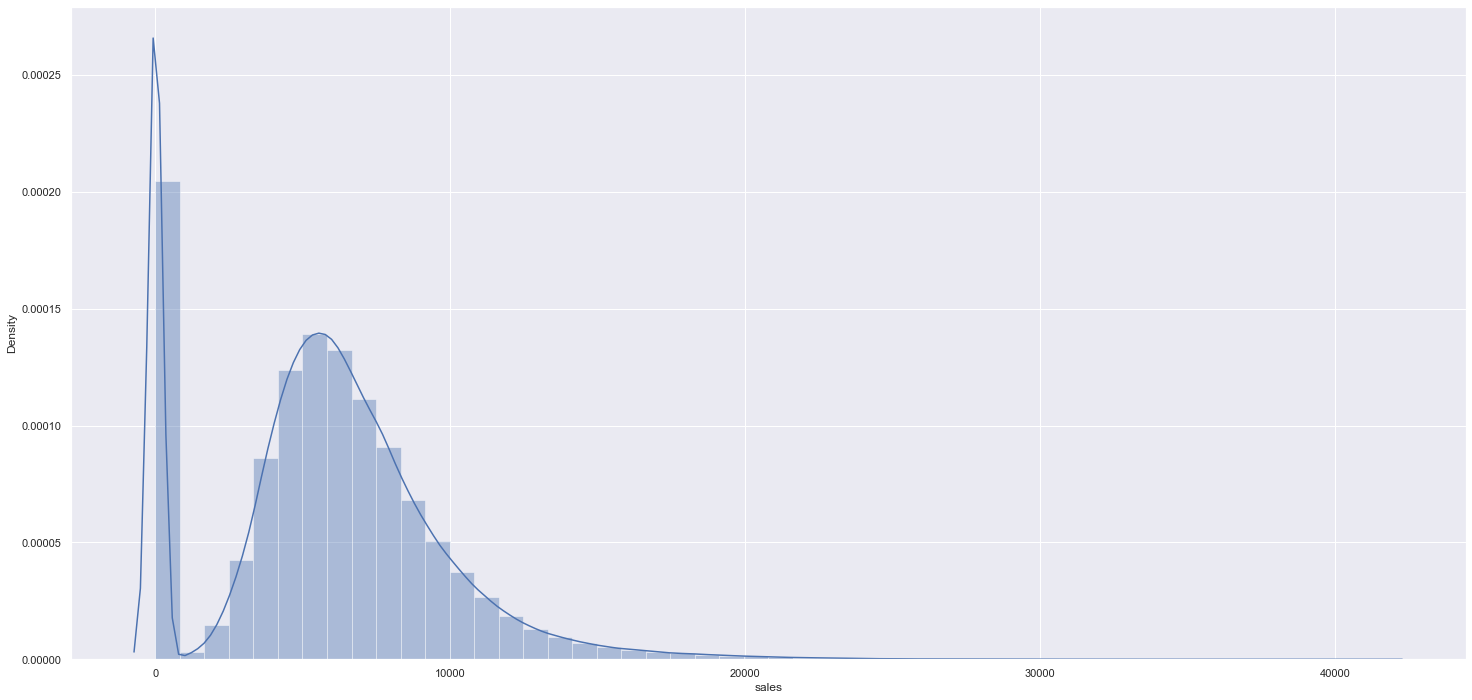

In [31]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [32]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Considerando que apenas os atributos state_holiday, store_type e o assortment.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

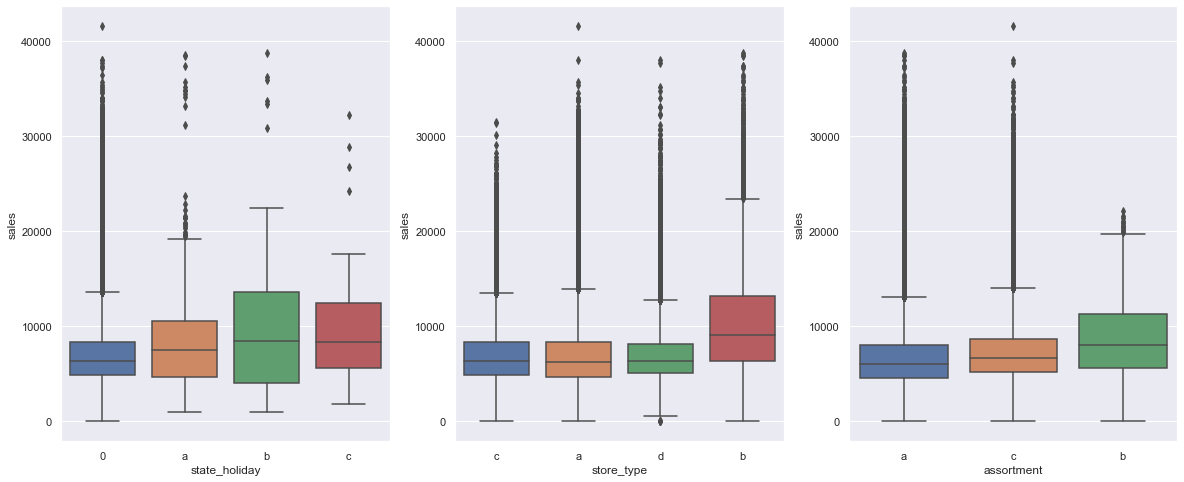

In [33]:
# Fazendo um filtro para retirar os dias que as lojas estiveram fechadas, ou seja, vendas iguais a zero. A coluna Open indica se a loja estava fechada no dia ou não.
aux = df1.loc[df1['open'] != 0]

plt.figure(figsize = [20,8])
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y= 'sales' , data= aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y= 'sales' , data= aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y= 'sales' , data= aux)

In [34]:
# aux1 = df1[(df1['state_holiday']!='0') & (df1['sales'] > 0)]
# sns.boxplot(x='state_holiday' , y= 'sales' , data= aux1)

### Observations

**Fig - 1**
- O feriado 'a' representa um feriado genérico, o 'b' representa a Páscoa, o 'c' representa o Natal e o '0' representa que não houve feriado.
- **Insight 01:** Ao observar a representatividade da venda nos feriados, percebe-se que o feriado da páscoa pode ser bem mais rentável que os outros.

# 2.0 Feature Engineering

In [35]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

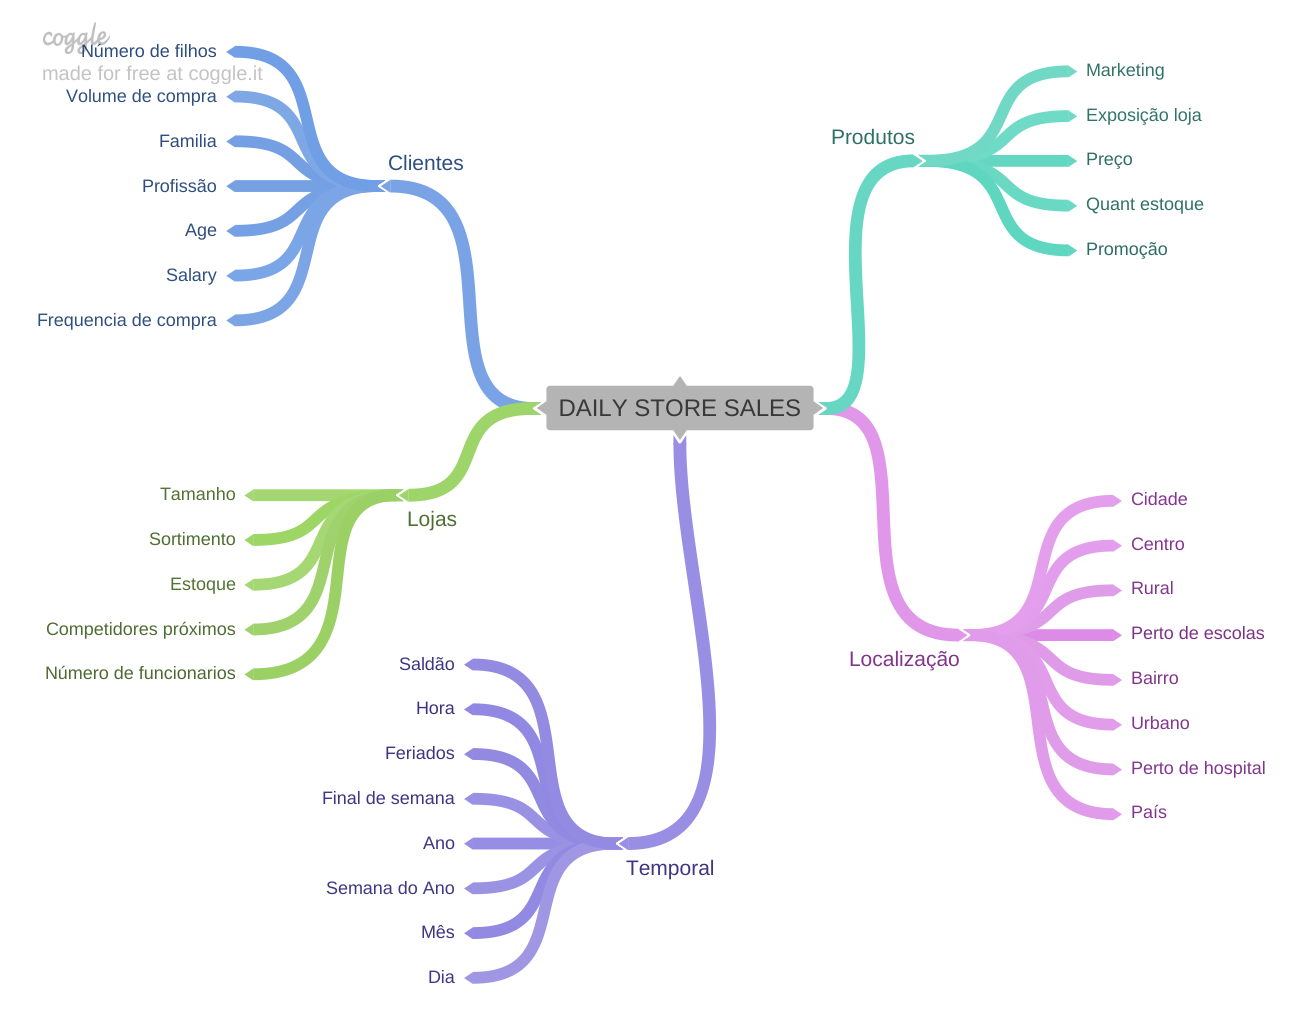

In [36]:
FILE_IMAGE_MAP_HYPOTHESIS = os.path.join(IMAGEDIR_HYPOTHESIS,'Mind_Map_Hypothesis.png')
Image(FILE_IMAGE_MAP_HYPOTHESIS)

## 2.2 Create Hipothesis

**Hipóteses não são causa e efeitos!**

A priorização de Hipóteses se dá pela disponibilidade dos dados.

### 2.2.1 Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores a mais tempo, deveriam vender mais.

### 2.2.2 Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição dos produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais promoções consecultivas deveriam vender mais

**7.** Lojas com mais dias de promoções deveriam vender mais.

### 2.2.3 Temporal

**1.** Lojas abertas durante o feriado do Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo trimestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Localização
**Sem dados**

### 1.2.5 Clientes
**Sem dados**

### Lista de hipóteses

Lojas

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo, deveriam vender mais.

Produtos

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecultivas deveriam vender mais

**6.** Lojas com mais dias de promoções deveriam vender mais.

Tempo

**7.** Lojas abertas durante o feriado do Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo trimestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [37]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['weekofyear'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#Competition Since (Composição do ano e do mês)
df2['competition_since']=df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1 ) #axis =1 pq estaremos usando mais de uma coluna
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week']=((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#Assortment
dict_assortment = {'a':'basic' , 'b':'extra', 'c':'extended'}
df2['assortment'] = df2['assortment'].map(dict_assortment)

#State Holiday
dict_holiday = {'a':'public_holiday', 'b':'Easter_holiday', 'c':'Christmas', '0':'Regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(dict_holiday)

# 3.0 Filtering Variables

In [38]:
df3= df2.copy()

In [39]:
df3.head(3).T

,0,1,2
store,1,2,3
day_of_week,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314
customers,555,625,821
open,1,1,1
promo,1,1,1
state_holiday,Regular_day,Regular_day,Regular_day
school_holiday,1,1,1
store_type,c,a,a


**RESTRIÇÕES DO NEGÓCIO:**
- Customers: Essa variável não vai está disponível para o modelo em produção (Pode ser retirado o atributo)
- Open: Não interesse em predizer a venda para lojas fechadas já que não faz sentido. Logo, deveremos filtrar essas linhas que tem open igual a 0. (Linhas a serem retiradas)
- Month Map: Apenas uma coluna auxiliar, logo pode ser retirada
- promo_interval:  Apenas uma coluna auxiliar, logo pode ser retirada
- Sales: Retirar as linhas em que as vendas foram iguais a zero. (Linhas a serem retiradas)

In [40]:
df3 = df3.loc[df3['open'] != 0]

In [41]:
cols_drop = ['customers' , 'month_map', 'promo_interval', 'open']
df3 = df3.drop(cols_drop , axis=1)

# 4.0 Exploratoy Analysis Data - EDA

**Como as variáveis impactam o fenômeno? e qual a força desse impacto?** => Regra geral do EDA

In [42]:
df4 = df3.copy()

In [43]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 4.1 Análise Univariada

### 4.1.1 Variável target

<AxesSubplot:xlabel='sales'>

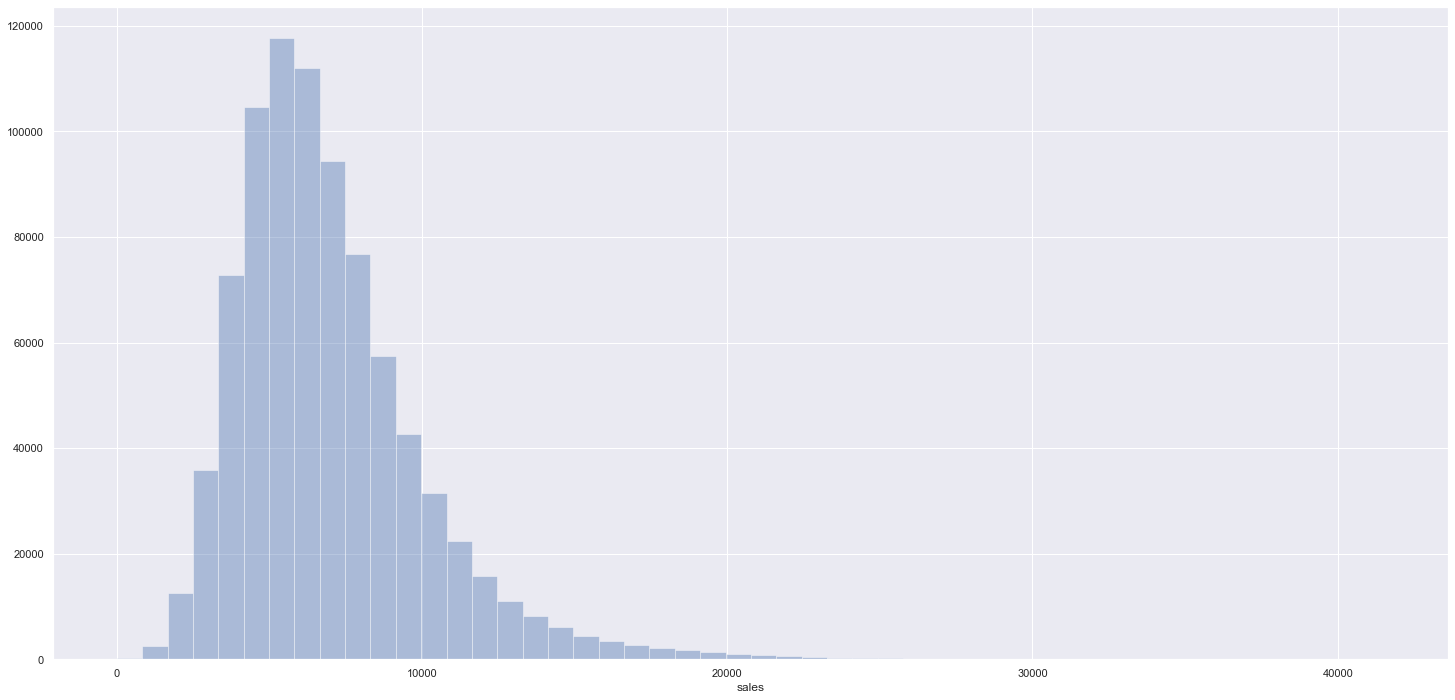

In [44]:
sns.distplot(df4['sales'], kde=False) # kde=True traça uma curva de densidade

Obs: A maioria dos algoritmos de ML foram performados com algumas condições, e uma delas, normalmente, é a curva de distribuição da variável target, de forma que quanto mais se aproxima de uma variável normal, melhor é o seu resultado.

Por isso, precisamos transformar a variável target de forma que corresponda a uma curva normal ou pelo menos tenha uma aparência semelhante.

Existem várias técnicas de transformação, como por exemplo o uso do log.

### 4.1.2 Numerical Variable

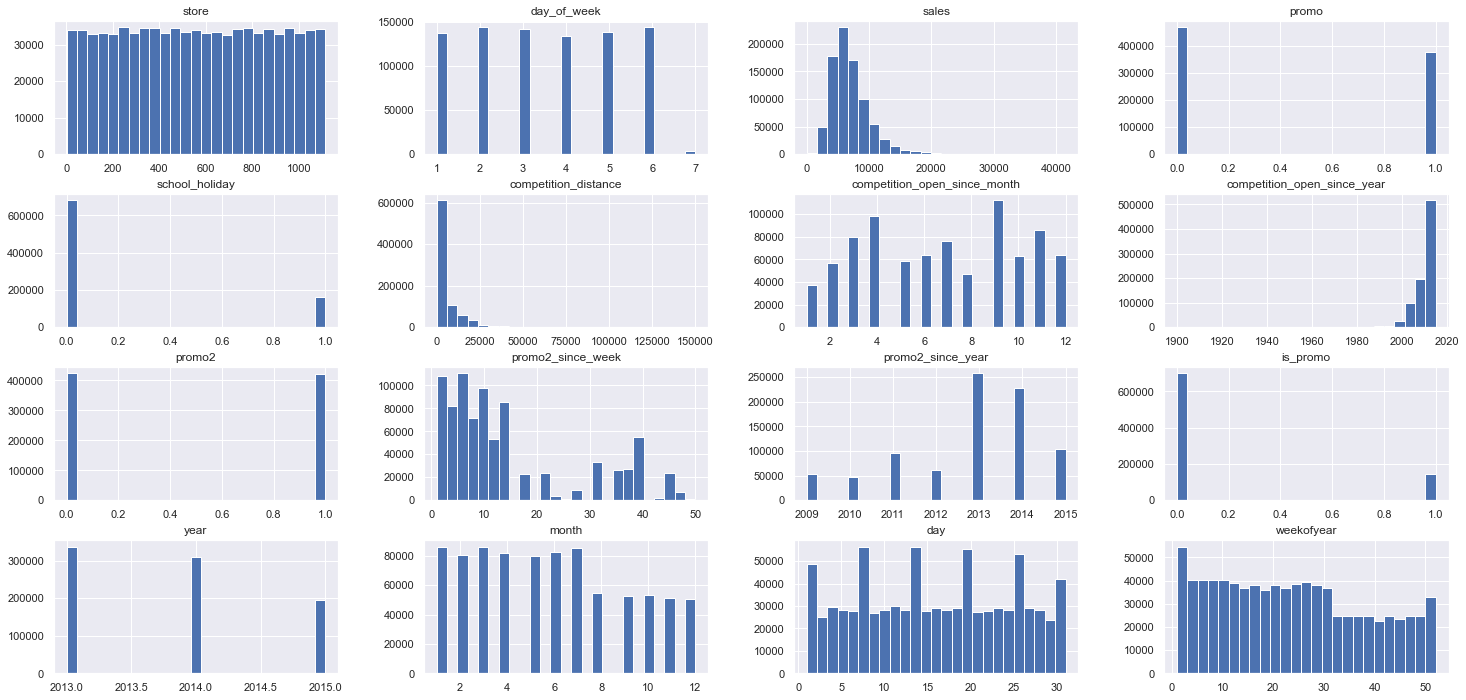

In [45]:
num_attributes.hist(bins=25);

**Lista de constatações:**
* As vendas tem uma menor frequência no domingo
* Tem mais vendas acontecendo quando não é tempo de promoção

### 4.1.3 Categorical Variable

In [46]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week',
       'competition_time_month', 'promo_time_week'],
      dtype='object')

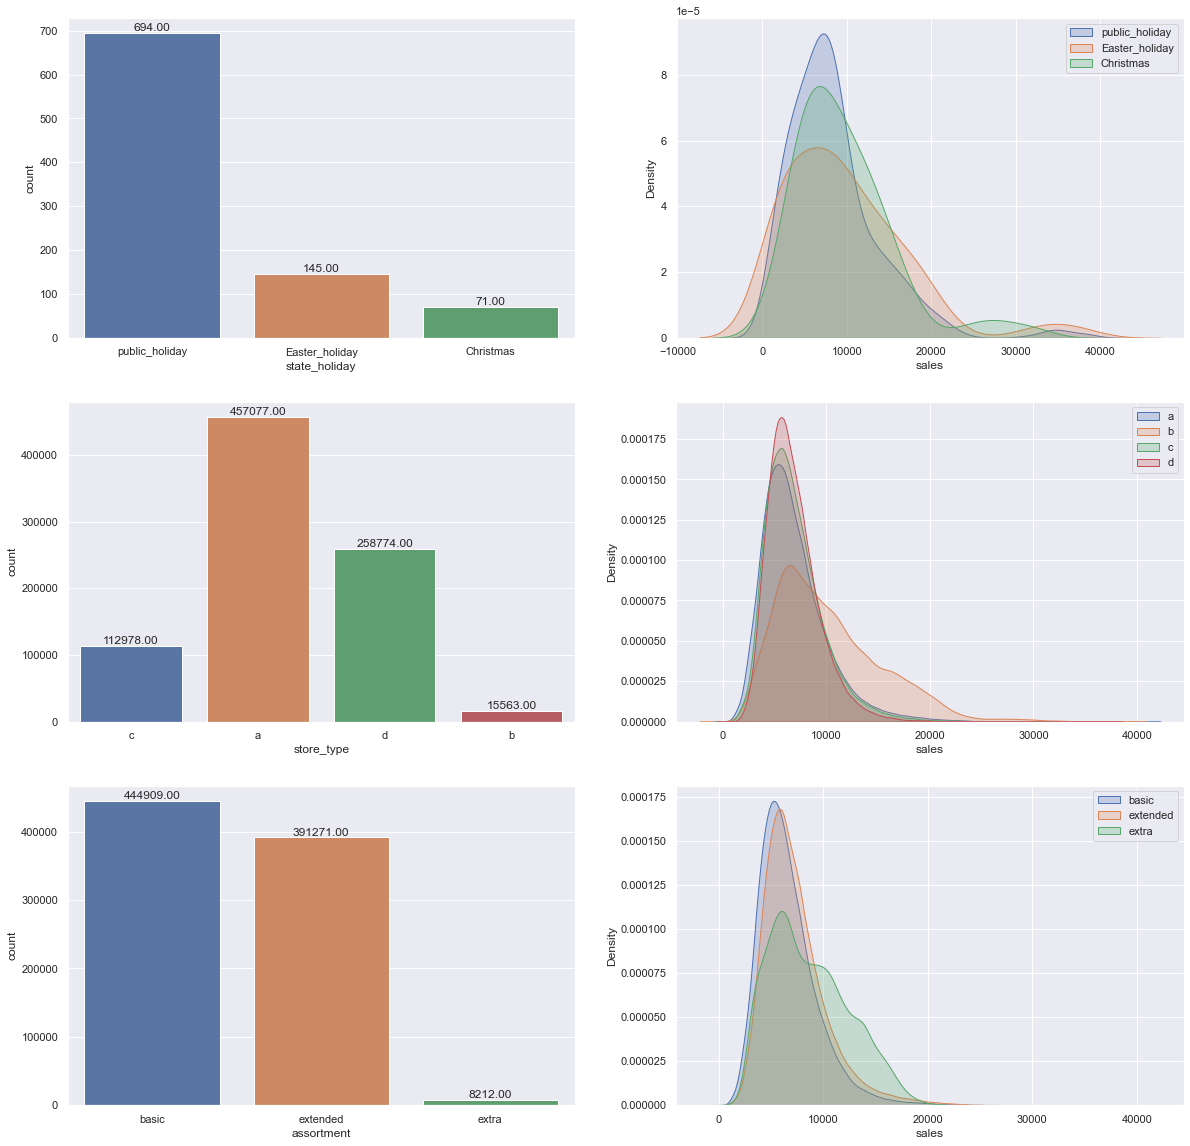

In [47]:
# Criar um grid com subplot
plt.figure(figsize=[20,20])
# State_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'Regular_day']
ax = sns.countplot(a['state_holiday'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'baseline', 
                xytext = (0,2), 
                textcoords = 'offset points')


plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],  
            label = 'public_holiday', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)

sns.kdeplot(df4[df4['state_holiday'] == 'Easter_holiday']['sales'],  
            label = 'Easter_holiday', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)


sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'],  
            label = 'Christmas', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)

plt.legend()
# Store_type
plt.subplot(3,2,3)
bx = sns.countplot(df4['store_type'])
for p in bx.patches:
    bx.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'baseline', 
                xytext = (0,2), 
                textcoords = 'offset points')



plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],  
            label = 'a', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)


sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],  
            label = 'b', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)


sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],  
            label = 'c', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True) 

sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],  
            label = 'd', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
cx= sns.countplot(df4['assortment'])
for p in cx.patches:
    cx.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'baseline', 
                xytext = (0,2), 
                textcoords = 'offset points')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],  
            label = 'basic', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)


sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],  
            label = 'extended', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)


sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],  
            label = 'extra', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True) 


plt.legend()


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

**FALSA - Lojas com maior sortimento vendem MENOS**

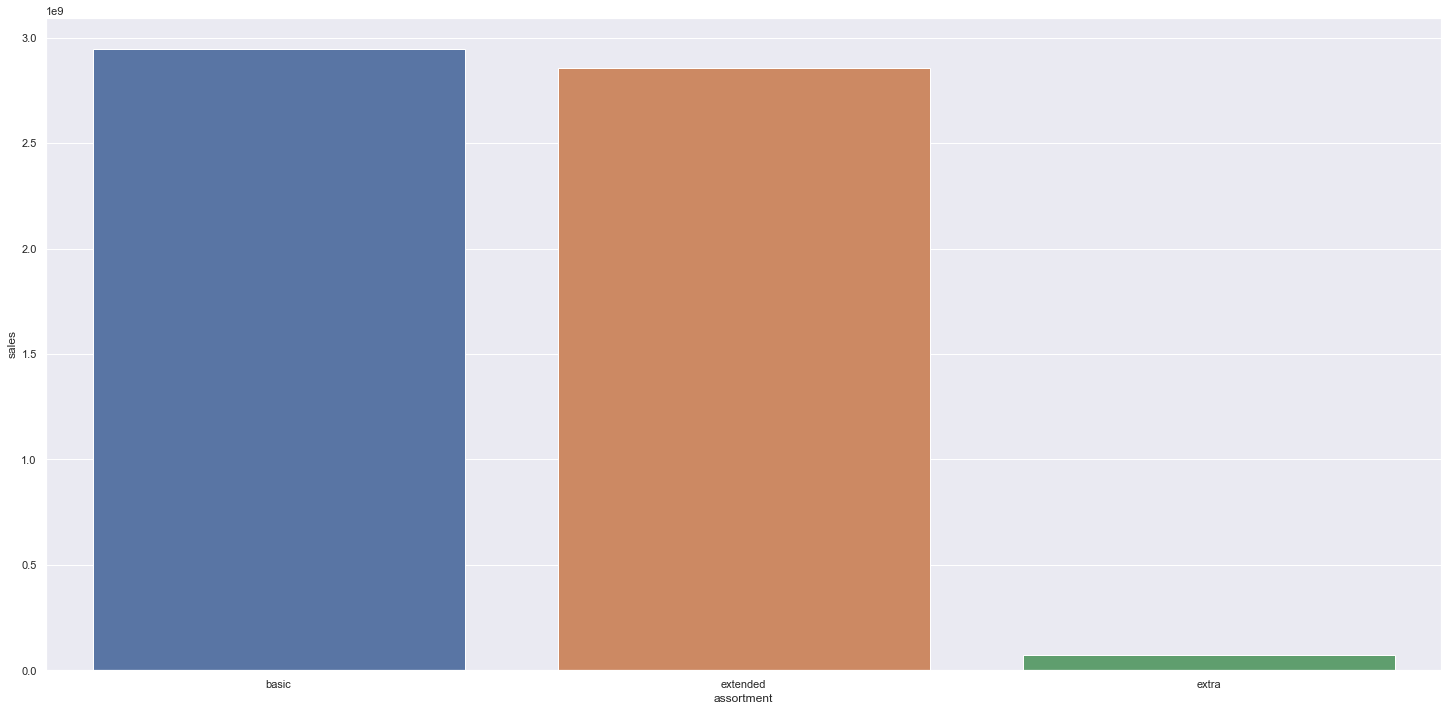

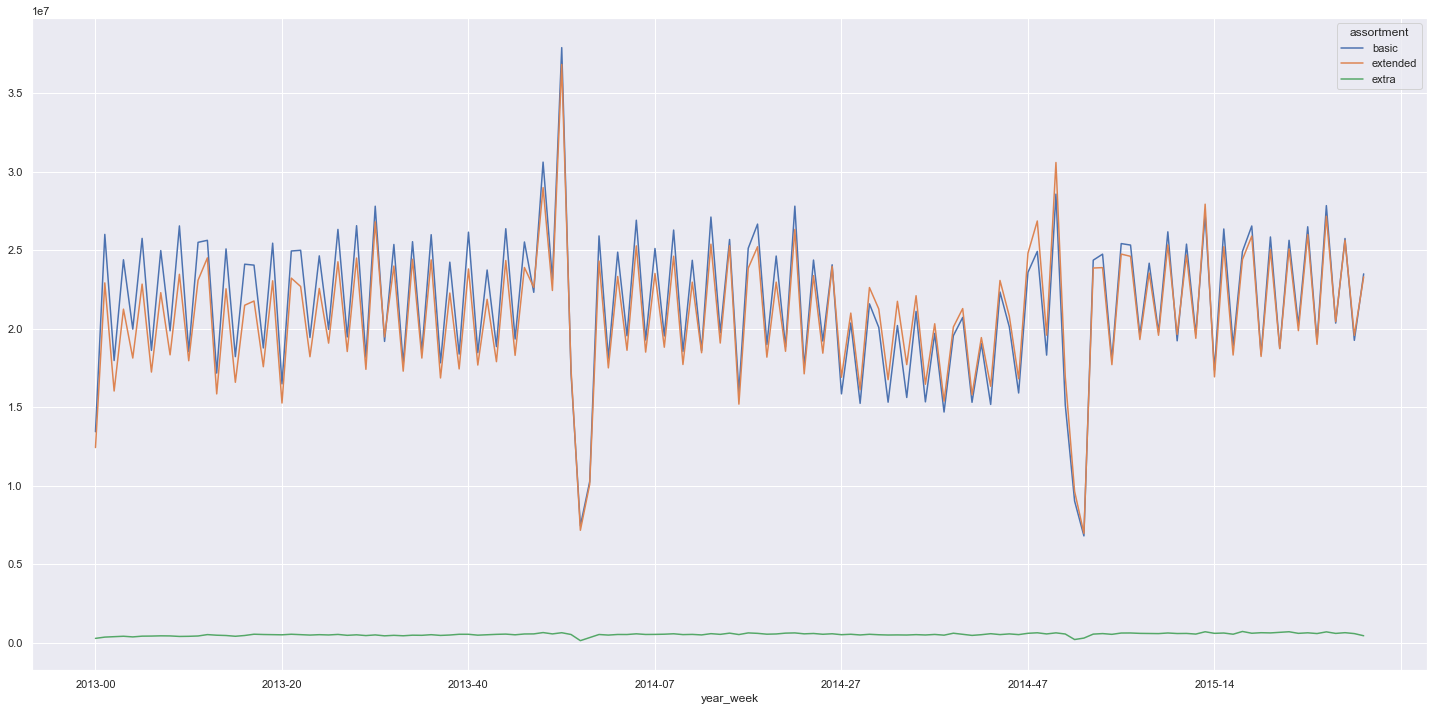

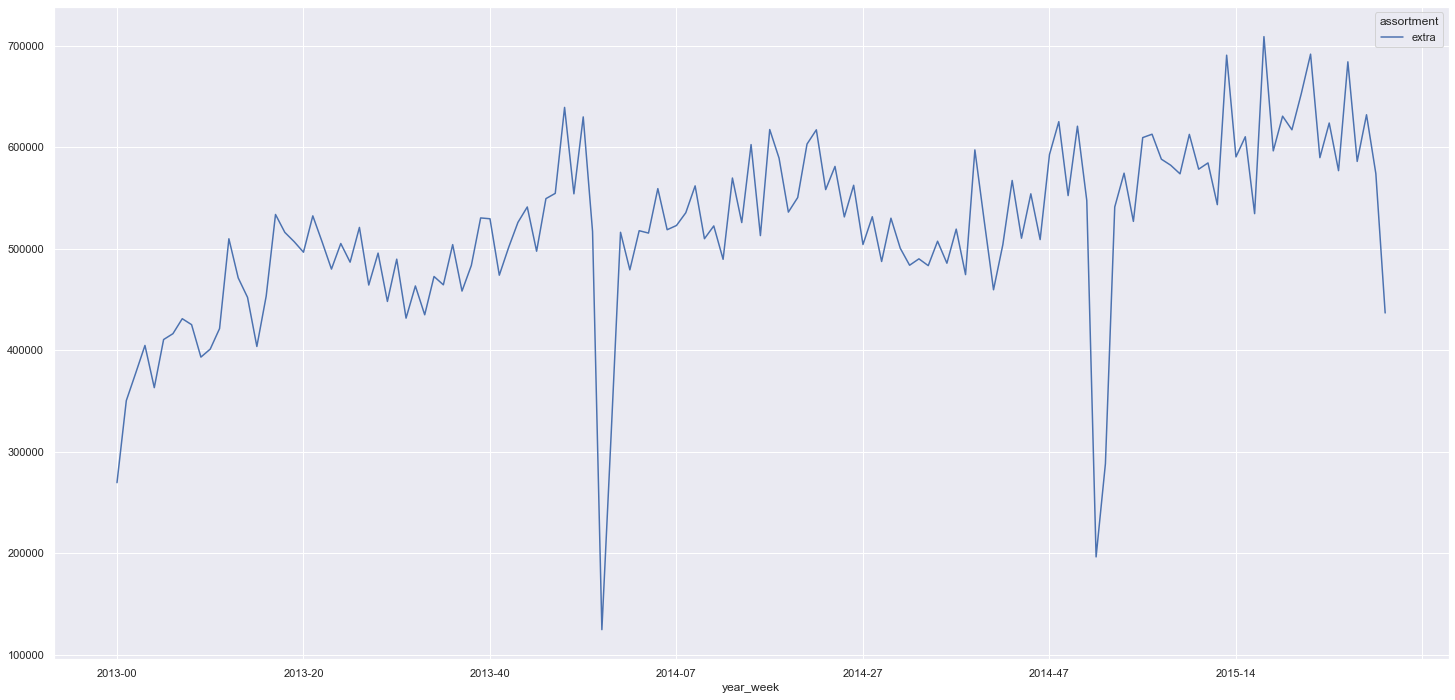

In [48]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales', data= aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index= 'year_week', columns= 'assortment', values= 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA - Lojas com competidores mais próximos vendem mais.**

<AxesSubplot:>

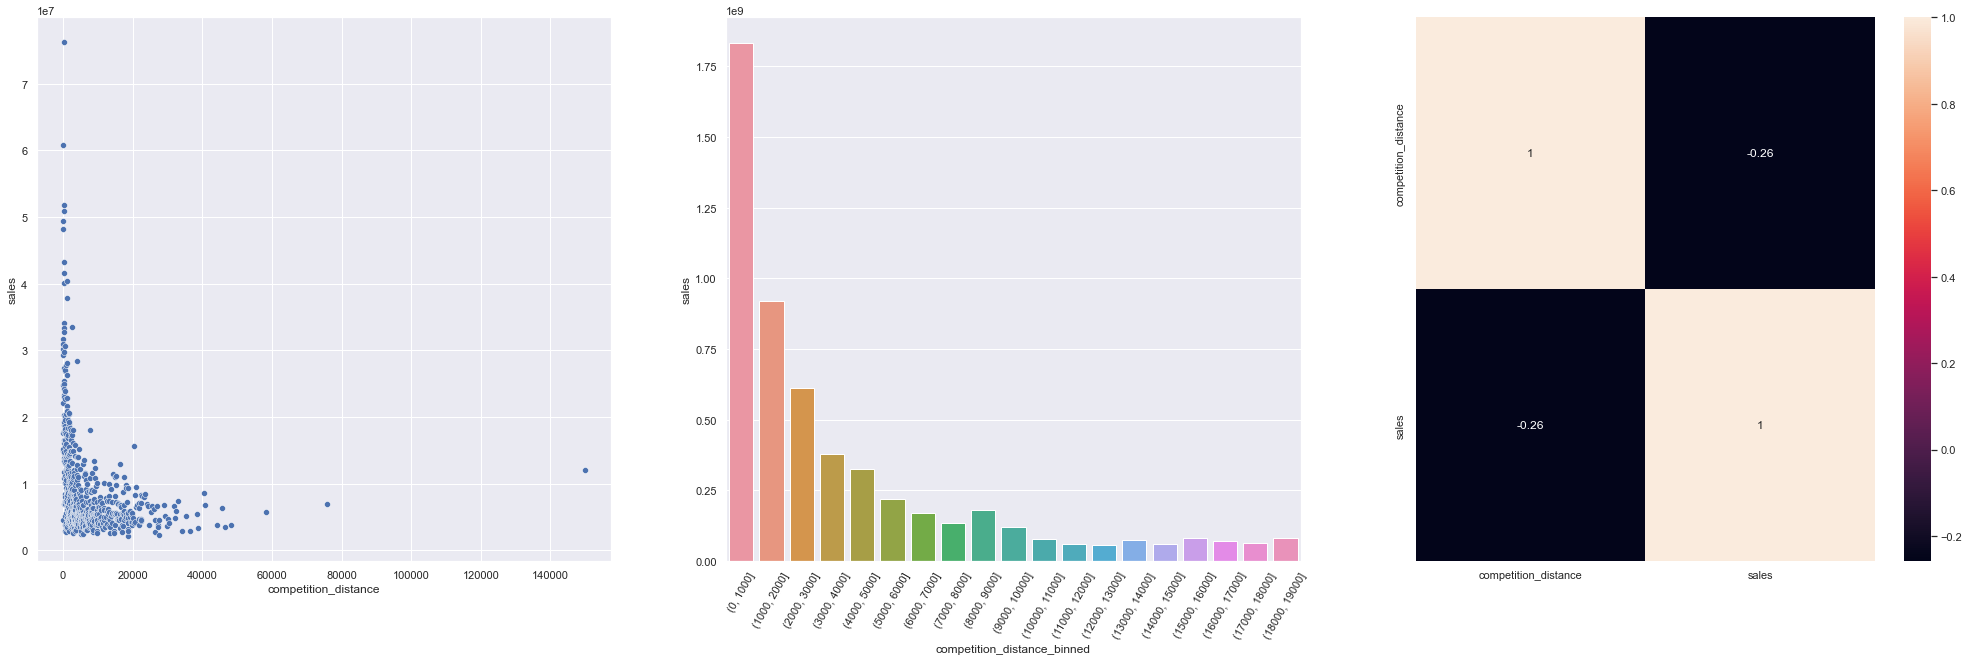

In [49]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize = [35,10])
plt.subplot(1,3,1)
# concentração dos dados
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

# Criando grupo de valores para reproduzir o gráfico em barras
bins = list( np.arange (0,20000, 1000))

plt.subplot(1,3,2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y= 'sales', data=aux2)
plt.xticks(rotation = 60)

plt.subplot(1,3,3)
# Força de correlação entre a target e a variável competition Distance
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)

### H3. Lojas com competidores à mais tempo deveriam vender mais.

**FALSA - Lojas competidores à mais tempo vendem menos que do que aqueles que competidores a menos tempo**

<AxesSubplot:>

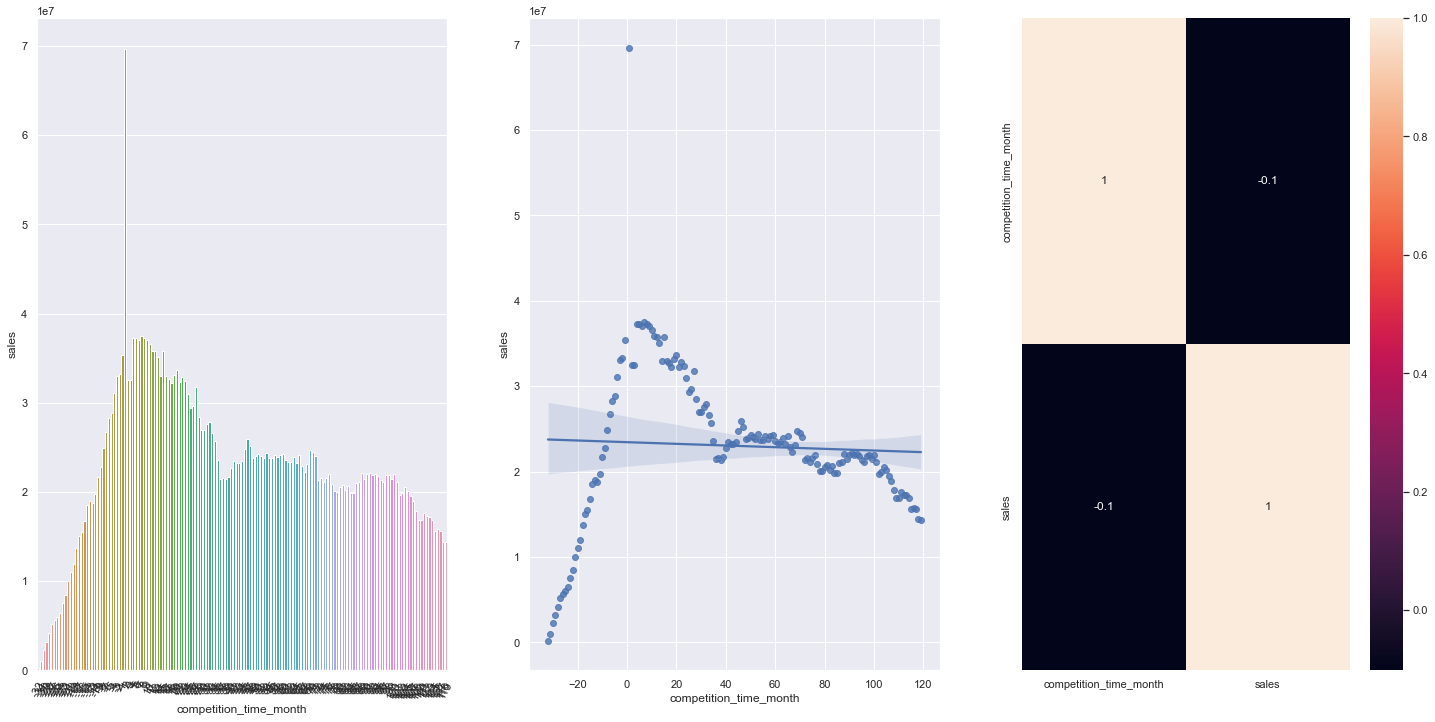

In [50]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation = 60)


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month' , y='sales', data=aux2)

# Verificando a relevância para o modelo
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)


### H4: Lojas com promoções ativas por mais tempo deveriam vender mais.

- **FALSA:** As lojas podem até vender mais até certo tempo, mas depois as vendas começam a decair.

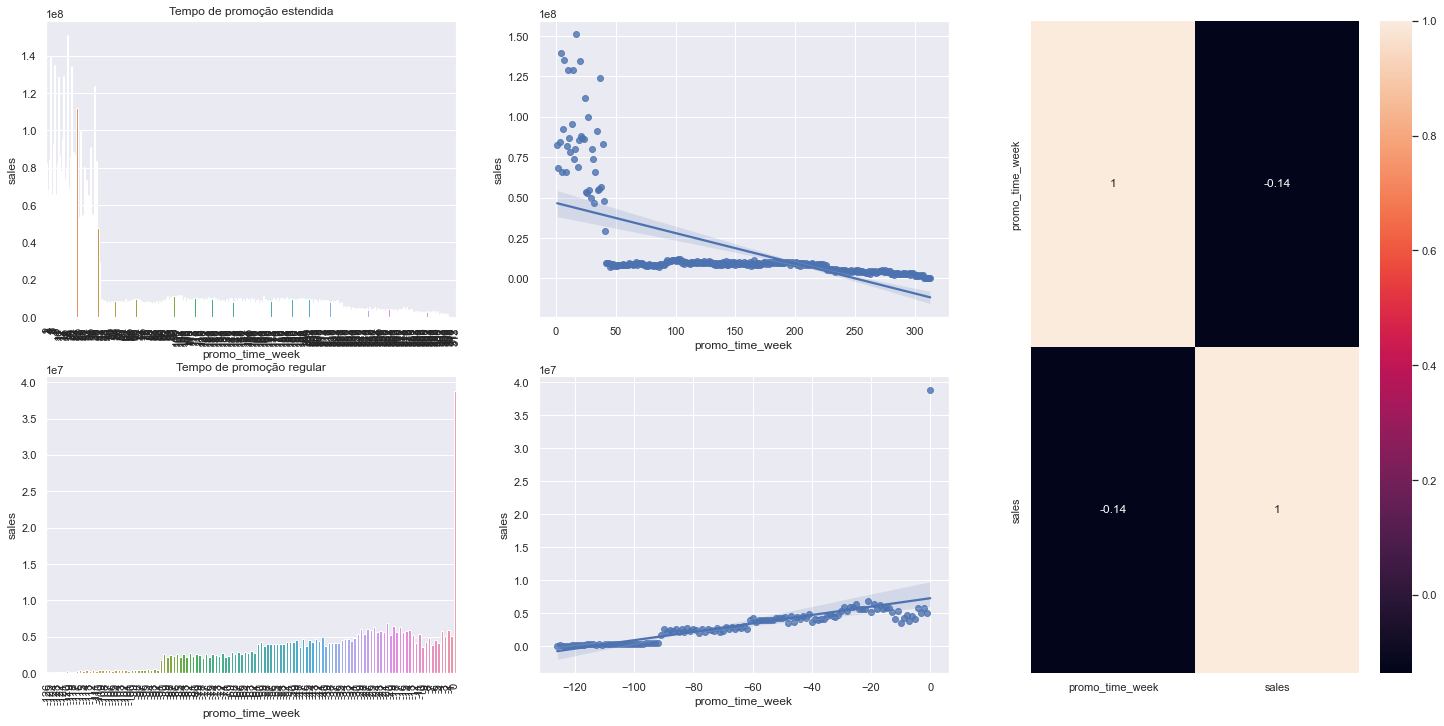

In [52]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x= 'promo_time_week',y='sales',data=aux1);

grid = plt.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']> 0] # Promo extendida
sns.barplot(x= 'promo_time_week',y='sales',data=aux2)
plt.title('Tempo de promoção estendida')
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week',y='sales',data=aux2)


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<= 0] # Promo regular
sns.barplot(x= 'promo_time_week',y='sales',data=aux3)
plt.title('Tempo de promoção regular')
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x= 'promo_time_week',y='sales',data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5: Lojas com mais dias de promoções deveriam vender mais.</s>

### H6: Lojas com mais promoções consecultivas deveriam vender mais.

Variáveis:
- promo
- promo2
- sales

In [53]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


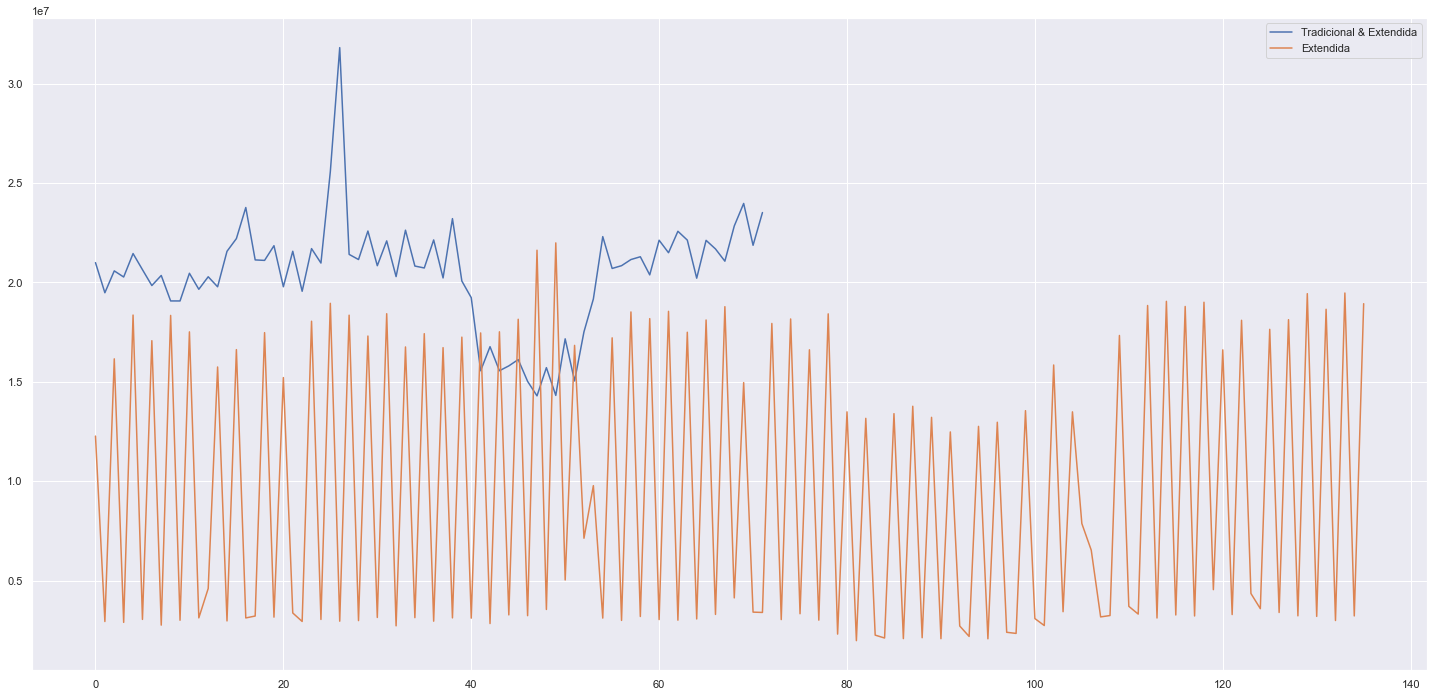

In [54]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 0) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

### **H7** Lojas abertas durante o feriado do Natal deveriam vender mais.

* **FALSA:** Lojas abertas durante o feriado do Natal vendem menos. Entretanto, deve-se considerar que o feriado de Natal só existe uma vez no ano.

<AxesSubplot:xlabel='year', ylabel='sales'>

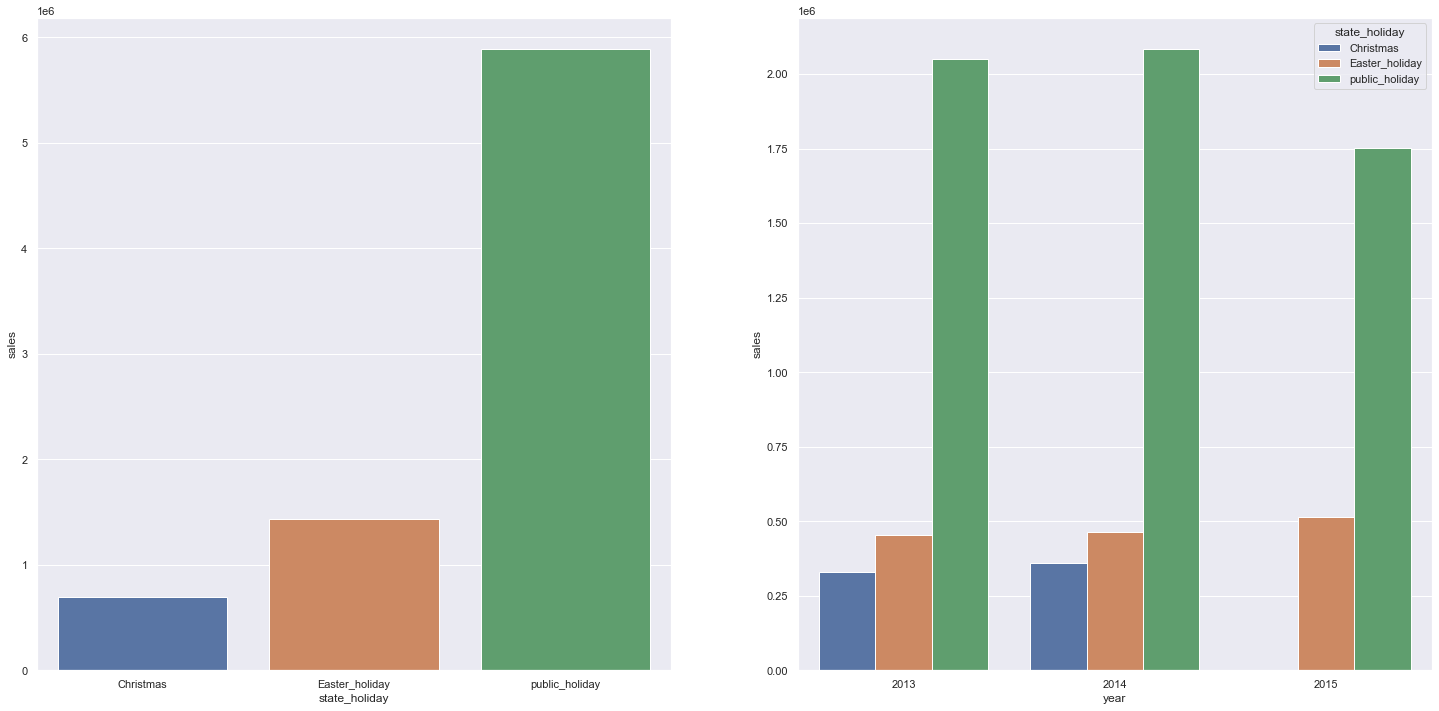

In [55]:
aux = df4[df4['state_holiday'] != 'Regular_day']

plt.subplot(1,2,1)
aux1 = aux[['sales', 'state_holiday']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['sales', 'state_holiday','year']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### **H8** Lojas deveriam vender mais ao longo dos anos.

* **FALSA:** As lojas vendem menos ao longo dos anos.

<AxesSubplot:>

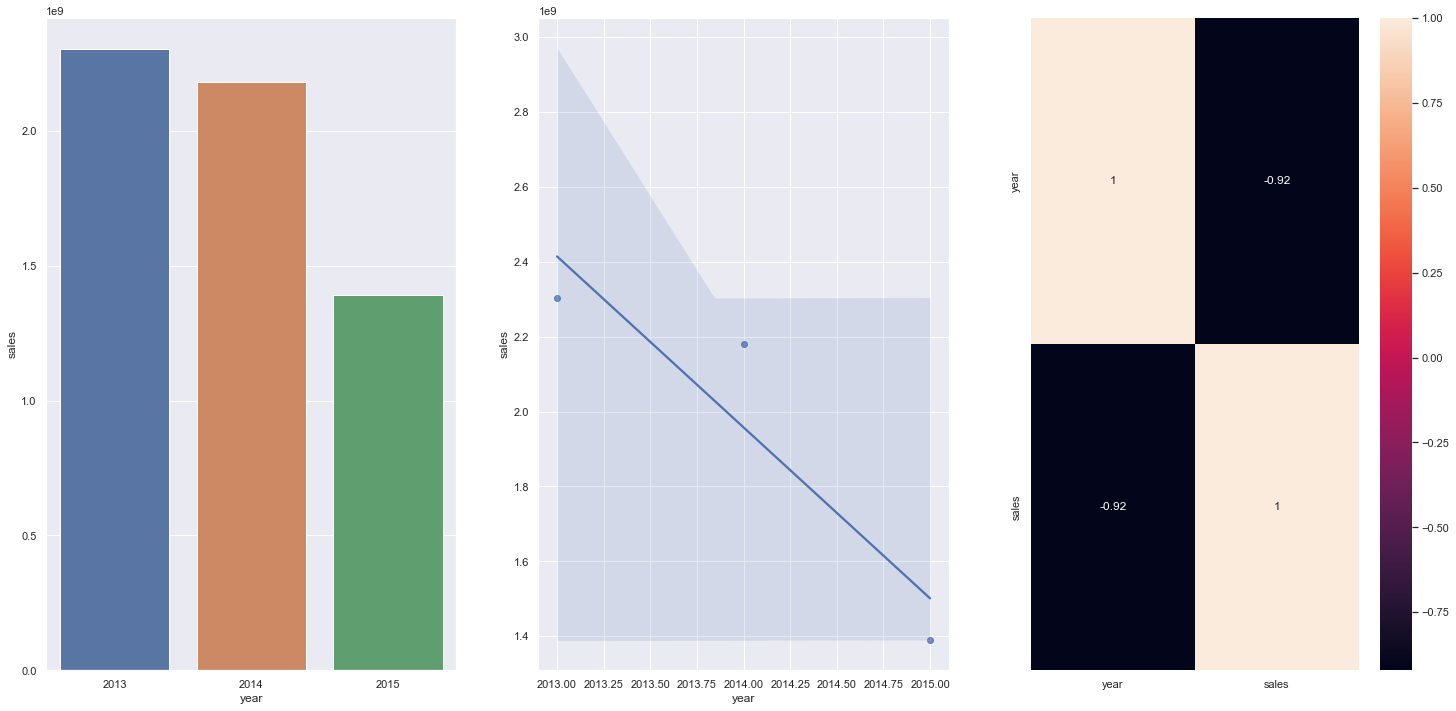

In [56]:
# Olhando a quantidade de vendas por ano
plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1);

# Olhando a linha de tendência dessas vendas
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);


# Observando o grau de correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9** Lojas deveriam vender mais no segundo semestre do ano.

* **FALSA:** As lojas vendem menos a partir do segundo semestre. Entretanto, o ano de 2015 parece não está completo, por tanto pode ser que essa hipótese se modifique com o ano fechado.

<AxesSubplot:>

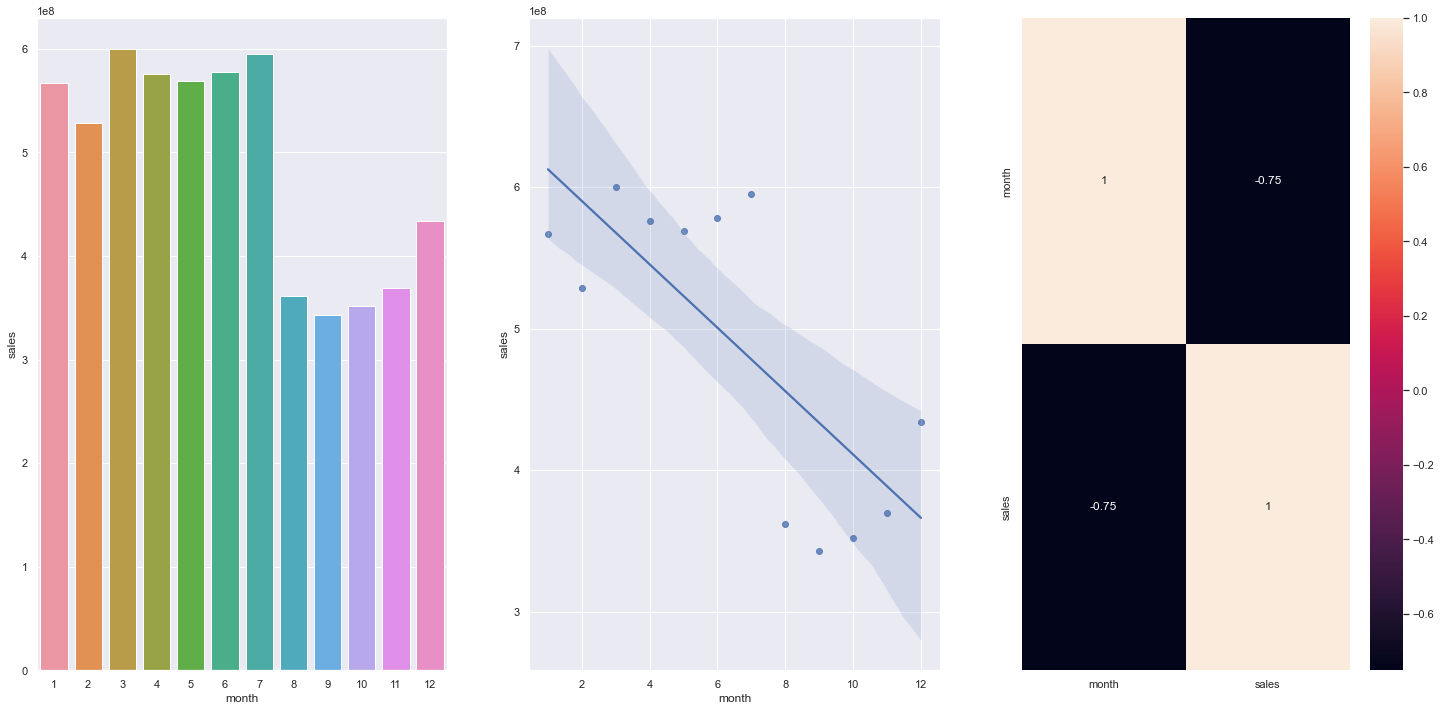

In [57]:
# Olhando a quantidade de vendas por ano

plt.subplot(1,3,1)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=aux1);

# Olhando a linha de tendência dessas vendas
plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);


# Observando o grau de correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA:** Lojas vendem mais depois do dia 10

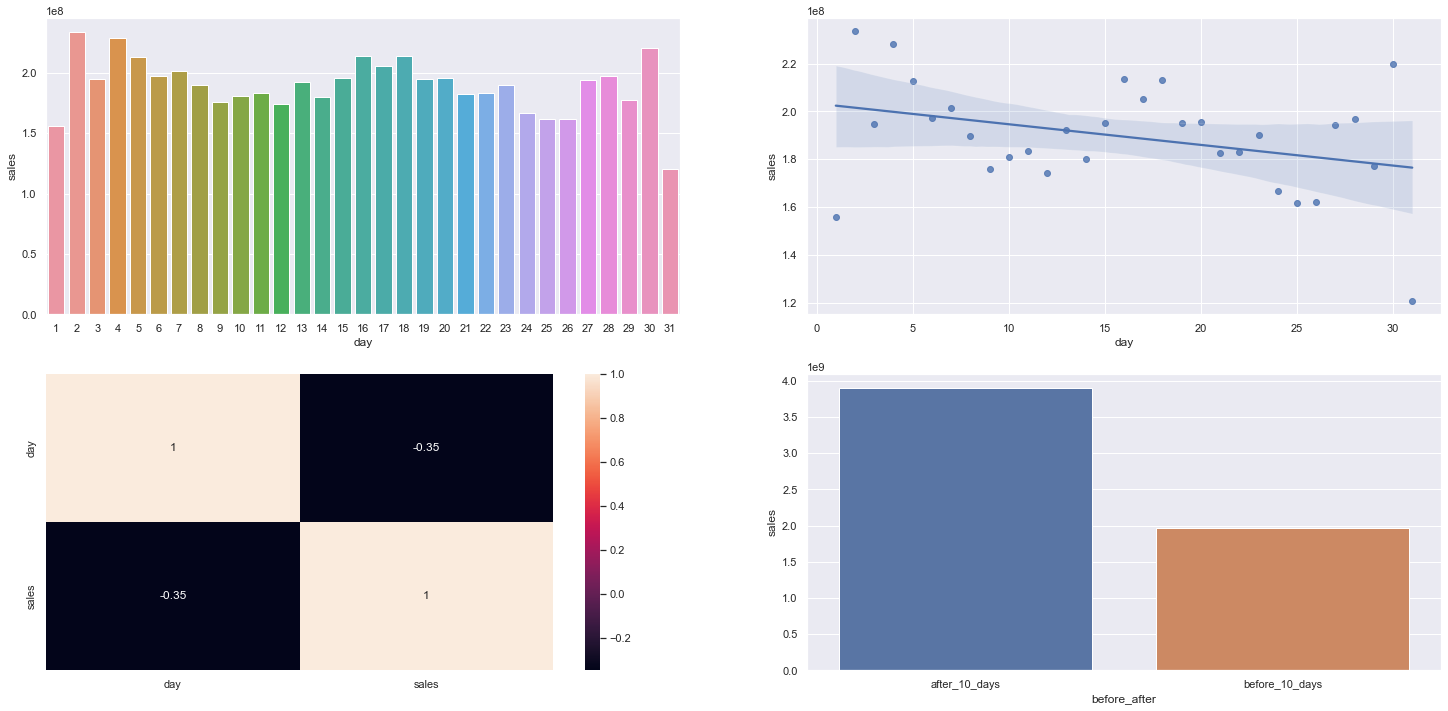

In [58]:
# Olhando a quantidade de vendas por ano
plt.subplot(2,2,1)
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')

sns.barplot(x='day',y='sales',data=aux1);

# Olhando a linha de tendência dessas vendas
plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);


# Observando o grau de correlação
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales',data=aux2);

### **H11** Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA:** Lojas vendem menos aos fins de semana.

<AxesSubplot:>

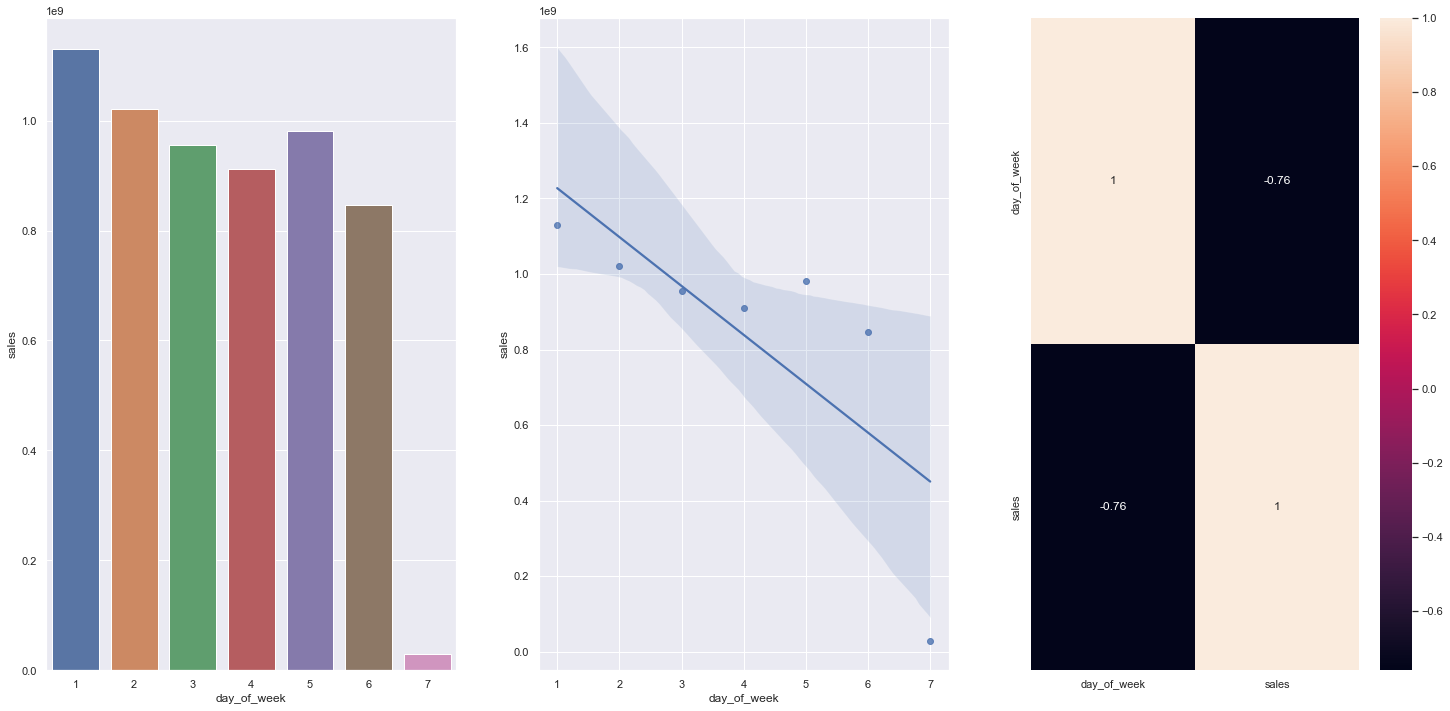

In [59]:
# Olhando a quantidade de vendas por ano
plt.subplot(1,3,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

sns.barplot(x='day_of_week',y='sales',data=aux1);

# Olhando a linha de tendência dessas vendas
plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);


# Observando o grau de correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H12** Lojas deveriam vender menos durante os feriados escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

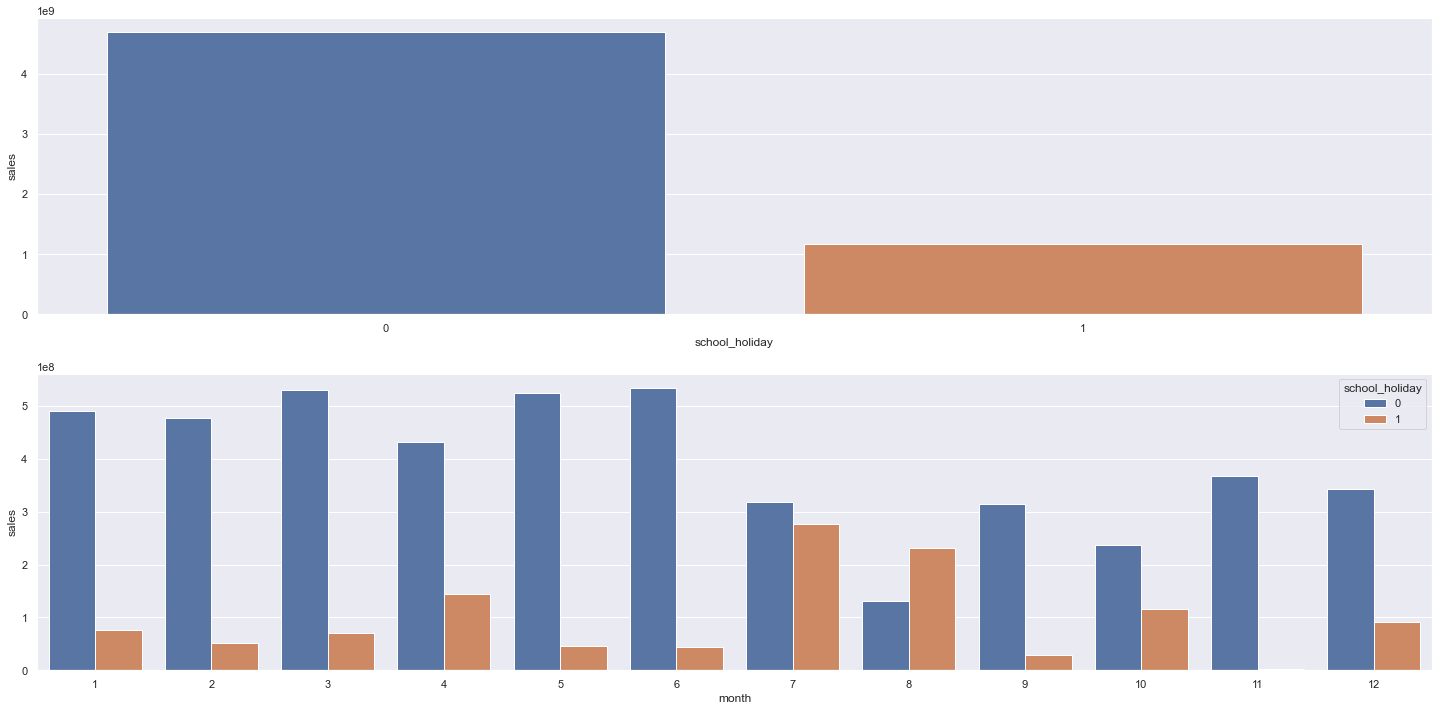

In [60]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday')

## 4.4 Análise multivariada

Teoria de Occam (Navalha de occam): Se tivermos vários modelos, temos que escolher o de menor complexidade. Ou seja, menor dimensionalidade (Menor números de colunas).
Para retirar algumas colunas se faz necessário analisar a perda de informação verificando a correlação com a variável target ou correlação entre variáveis de entrada diferentes.

Existem técnicas mais avançadas para redução de dimensionalidade no qual reduz drasticamente a perda de informação, caso fosse feita de forma manual.

### 4.4.1 Numerical Attributes

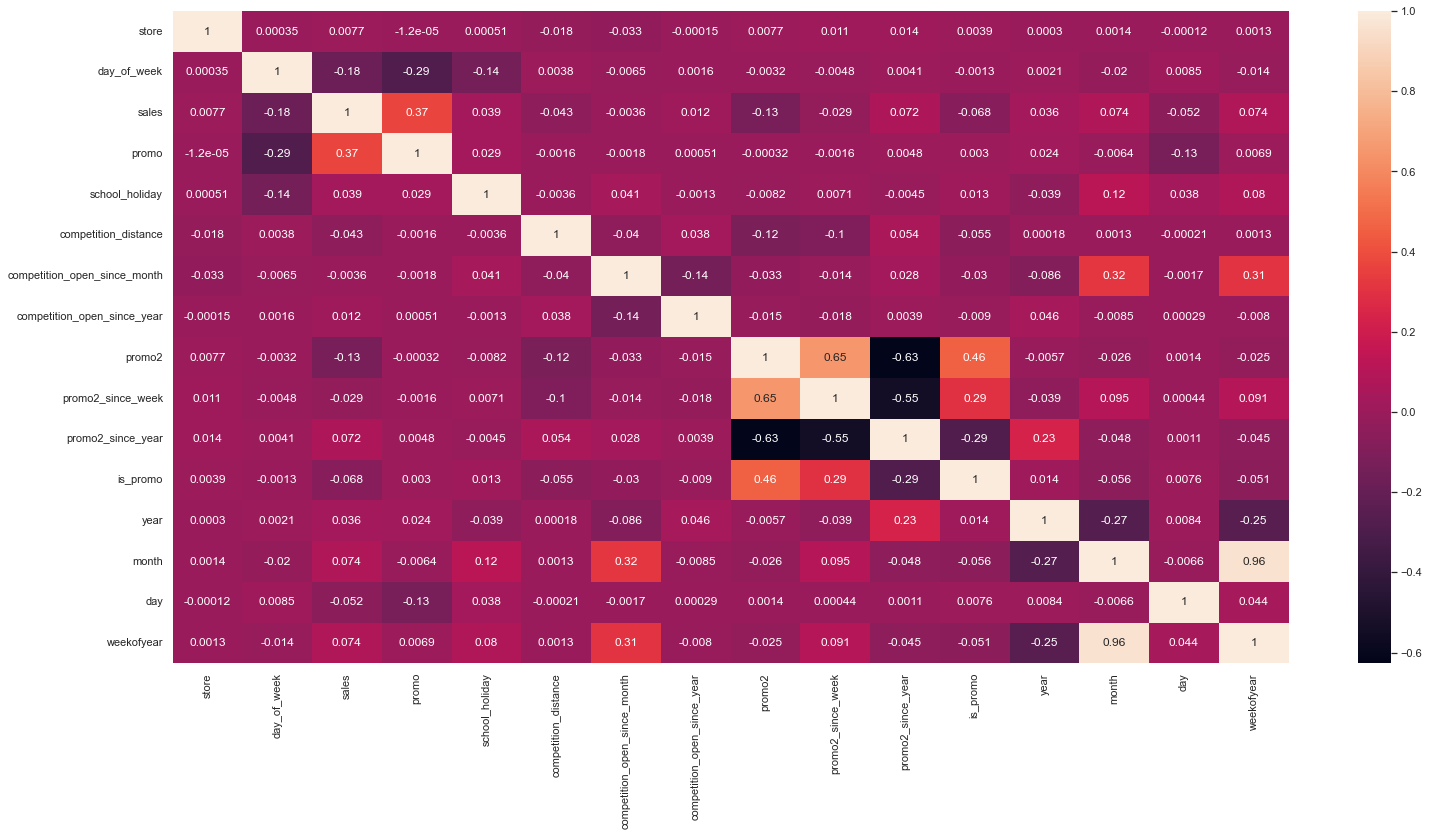

In [61]:
correlation = num_attributes.corr(method= 'pearson')
sns.heatmap( correlation, annot = True);

### 4.4.2 Categorica Attributes

Será utilizado o método Cramer V para fazer o cálculo de correlação entre variáveis categóricas

In [62]:
# Only categorical Data
a = cat_attributes.drop(columns='year_week')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
                'store_type':[a4,a5,a6],
                'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

<AxesSubplot:>

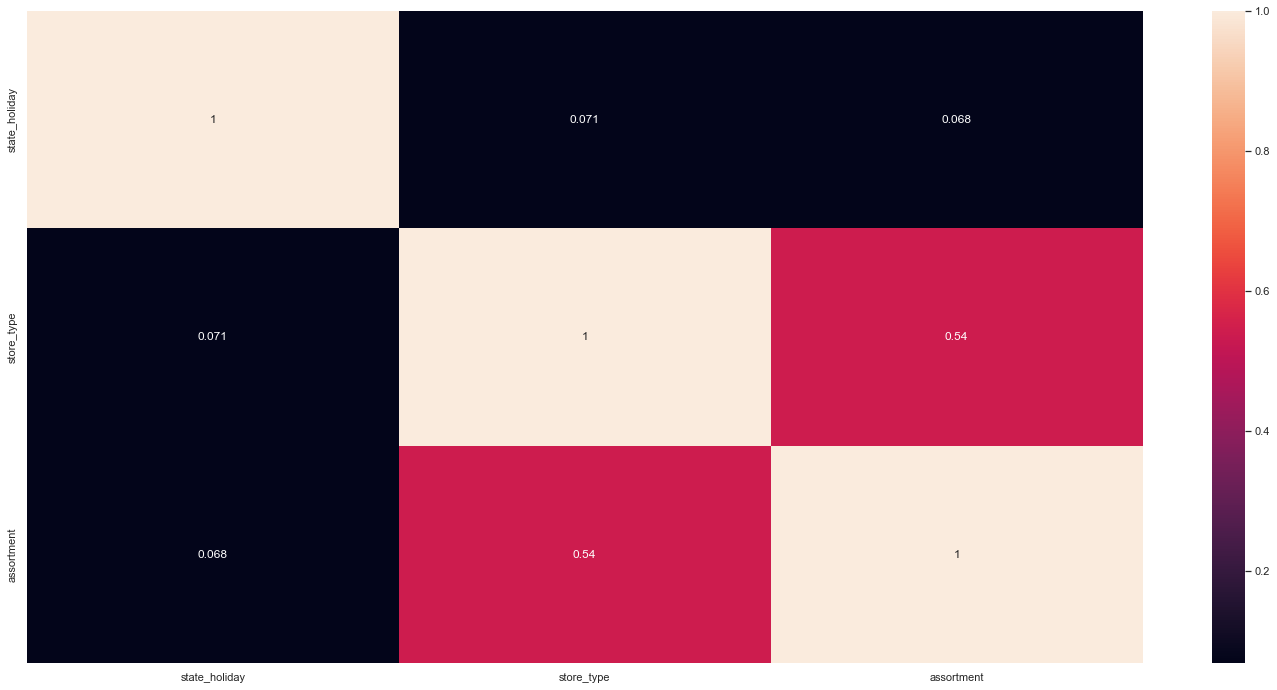

In [63]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [64]:
df5 = df4.copy()

## 5.1 Normalização/Padronização

Como não há variáveis numéricas com distribuição normal, então não precisa utilizar esse tipo de transformação de escala.

## 5.2 Rescaling

**Na presença de outliers podemos utilizar o RobustScaler para a transformação dos dados em uma nova escala, e caso não tenha outliers, poderá ser utilizado o método MinMaxScaler**

In [65]:
rs = RobustScaler()
mms = MinMaxScaler()


# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) # Coloca-se dois colchetes para pegar o valor da coluna.

# year - sem outlier
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week - sem outlier
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## 5.3 Encoding

In [66]:
# state_holiday - Método OHE (Get_dummies)
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoder (Aleatoriamente trocando as letras por números)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal (Esse método deve ser utilizado uma vez que temos uma ordem de grandeza em relação as categorias)
dict_assortment = {'basic':0,
                    'extra': 1,
                    'extended':2}
df5['assortment'] = df5['assortment'].map(dict_assortment)

## 5.4 Transformation

### 5.4.1 Responsible variable transformation

Fazendo com o que a Variável resposta tenha uma distribuição mais próxima da normal. Nesse ciclo, iremos utilizar o método de transformação logarítimica.

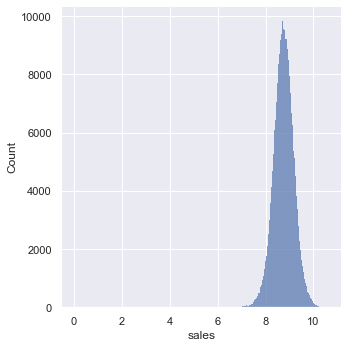

In [67]:
df5['sales'] = np.log1p(df5['sales'])
sns.displot(df5['sales'])

## 5.5 Transformação cíclica

In [68]:
# day_of_week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['weekofyear_sin']= df5['weekofyear'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['weekofyear_cos']= df5['weekofyear'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


# 6.0 Feature Selection

Nesse capítulo será abordado o Algoritmo Boruta para compreensão de quais Features são relevantes para o nosso modelo.

In [69]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and test Dataset

O ideal seria dividir em treino, teste e validação (Double Check).

Variáveis originais que geram outras no Feature engineering devem ser deletadas.

In [70]:
cols_drop = ['weekofyear', 'day_of_week','month','day','promo_since', 'competition_since','year_week']
df6 = df6.drop(cols_drop , axis=1)

In [71]:
from datetime import timedelta


df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [72]:
# Training Dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Testing Dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

In [73]:
x_train['date'].min()

Timestamp('2013-01-01 00:00:00')

## 6.2 Boruta as Feature Selector

In [78]:
# Define Train and Test DataSet for Boruta
x_train_n = x_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel() # O Ravel serve para deixar os valores tudo em um vetor

In [79]:
# Define Random Forest for Boruta
rf = RandomForestRegressor(n_jobs= -1) #O parâmetro -1 indica que o RandomForest tem que utilizar todos os CORES da máquina e faça todo o processamento em paralelo

In [80]:
boruta = BorutaPy(rf, n_estimators=15, verbose=2,random_state=42).fit(x_train_n,y_train_n)